# Effective Receptive Field

In [1]:
from unet import UNet
from utils.config import load_config
from utils.metrics import dice_score
from trf import compute_trf
from matplotlib import pyplot as plt
from IPython.display import Image, display
from torch.utils.data import DataLoader
from utils.data import SegmentationDataset
from preprocess_data import ALL_DATASETS
from scipy import signal
import matplotlib.patches as patches
import numpy as np
import torch
import glob
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

For U-Net, the ERF is input-dependent (rather than a function of its parameters) because of the max-pooling. In Luo's paper it is stated that the ERF is the partial derivative of the output w.r.t. the input, so I use torch.autograd to compute this. I compute this for every input image and take the average of all of them because if the input dependence.

I have also designed a new metric called "ERF rate" which computes the rate of the values in the ERF higher than a certain treshold (>0.025) relative to the total number of pixels in the TRF. The `rf_zone[rf_zone > 0.025].mean()` is to give a reward for a higher intensity

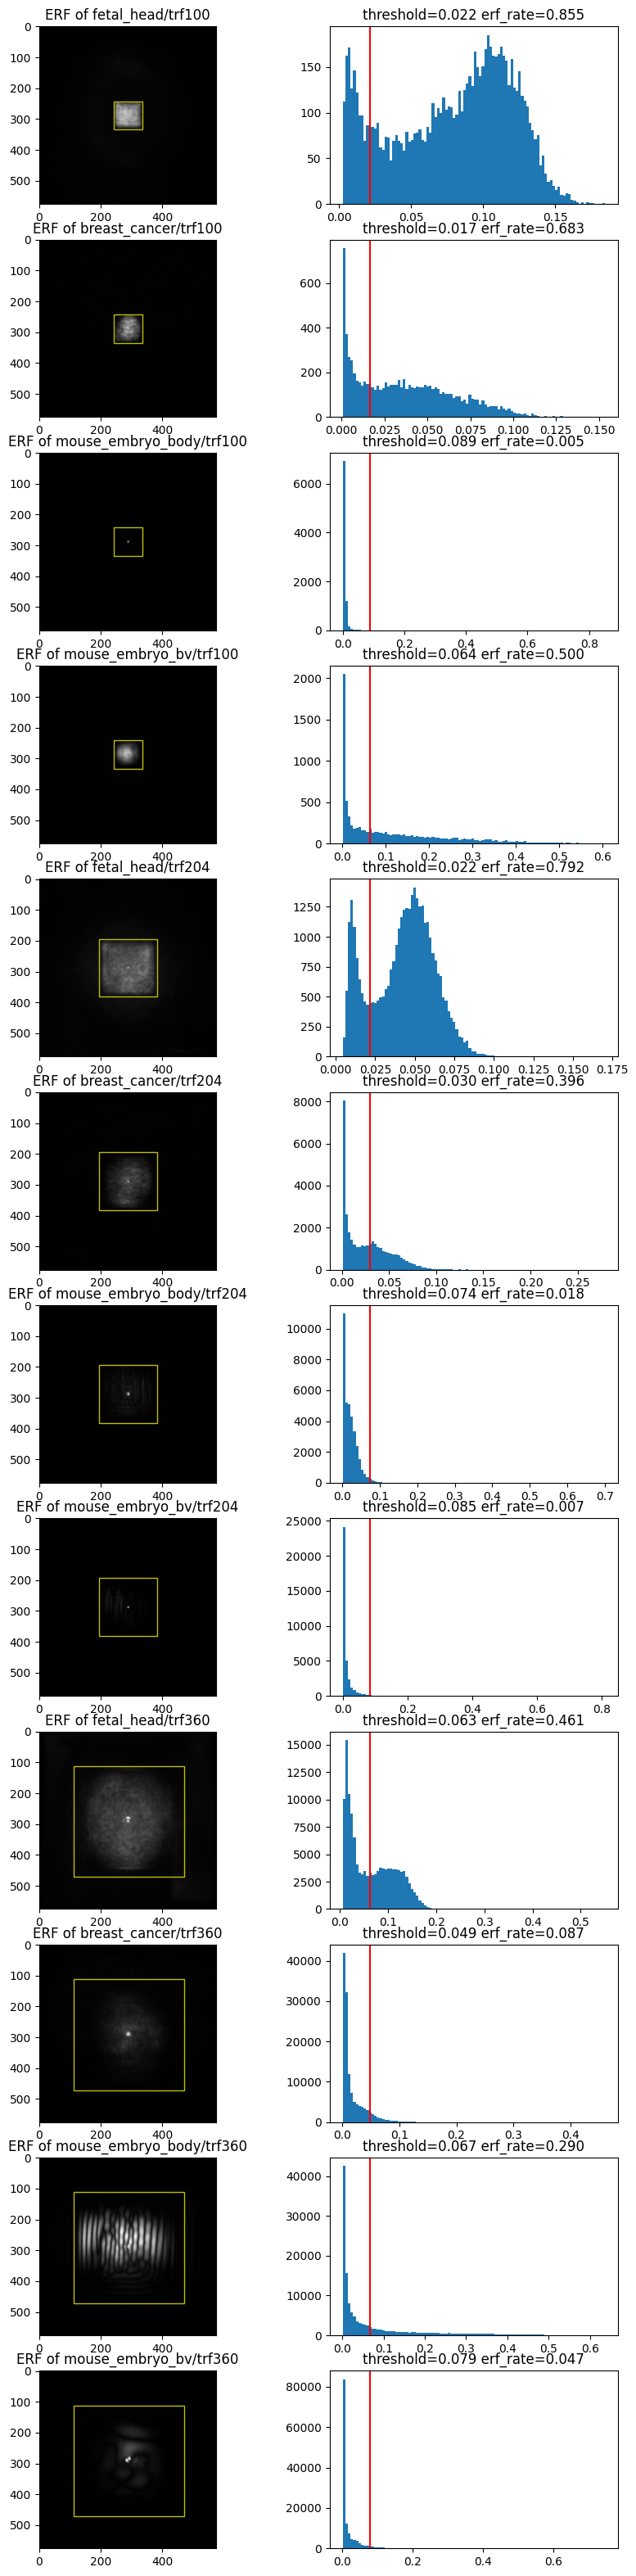

In [37]:
configs = ["trf100", "trf204", "trf360"]

fig, axs = plt.subplots(len(configs) * len(ALL_DATASETS), 2, figsize=(10, 40))

row = 0

for m, configname in enumerate(configs):

    config = load_config(configname)
    model = UNet(config).to(device)
    trf, pos = model.pixel_trf(576//2, 576//2), (576//2, 576//2)

    for dataset_name in ALL_DATASETS:
        model.load_state_dict(torch.load(f"out/{dataset_name}/{configname}/best_model.pt")["model_state_dict"])
        # model.eval()

        inputs = glob.glob(os.path.join(f"data/preprocessed/{dataset_name}/test", "*.png"))
        masks = glob.glob(os.path.join(f"data/preprocessed/{dataset_name}/test/masks", "*.png"))
        dataset_test = SegmentationDataset(inputs, masks)
        dataloader_test = DataLoader(dataset_test, shuffle=True)

        dist = np.zeros((576, 576, len(dataloader_test)))

        for i, (x, _) in enumerate(dataloader_test):
            x.requires_grad = True
            x = x.to(device)
            out = model(x)
            out_center = out[:, :, 288, 288]

            d = torch.autograd.grad(out_center, x)[0]
            
            # normalize for visualization
            d = torch.abs(d)
            d = (d - d.min()) / (d.max() - d.min())

            img = d.detach().cpu().numpy()
            img = np.squeeze(img)

            dist[:, :, i] = img


        img = np.mean(dist, axis=2)

        axs[row, 0].imshow(img, cmap="gray")

        start = trf[0, 0], trf[0, 1]
        len_x = trf[1, 0] - trf[0, 0] + 1
        len_y = trf[1, 1] - trf[0, 1] + 1
        patch = patches.Rectangle(start, len_x, len_y, linewidth=1, edgecolor='y', facecolor='none')
        axs[row, 0].add_patch(patch)
        axs[row, 0].set_title(f"ERF of {dataset_name}/{configname}")

        rf_zone = img[start[0]:start[0] + len_y, start[1]:start[1]+len_x]

        data = rf_zone.ravel()
        nbins = 100
        hist, bin_edges = np.histogram(data, bins=nbins)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

        axs[row, 1].hist(data, bins=nbins)
        n_range = nbins // 10

        for i, bin in enumerate(hist):
            if bin < np.mean(hist[i-n_range:i+n_range//2]):
                threshold = bin_centers[i]
                erf_rate = np.sum(rf_zone > threshold) / (len_x*len_y) * (1 + rf_zone[rf_zone > threshold].mean())
                axs[row, 1].set_title(f"threshold={threshold:.3f} erf_rate={erf_rate:.3f}")
                axs[row, 1].axvline(x=threshold, color="red")
                break

        row += 1

    del model

    
plt.show()